In [1]:
import cv2
import os
import subprocess
from astropy.io import fits,ascii
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.table import Table
import multiprocessing
from astropy.table import Table

In [2]:
os.chdir("/home/alam/task/task-inspecity/source-ex")

(2080, 3072)


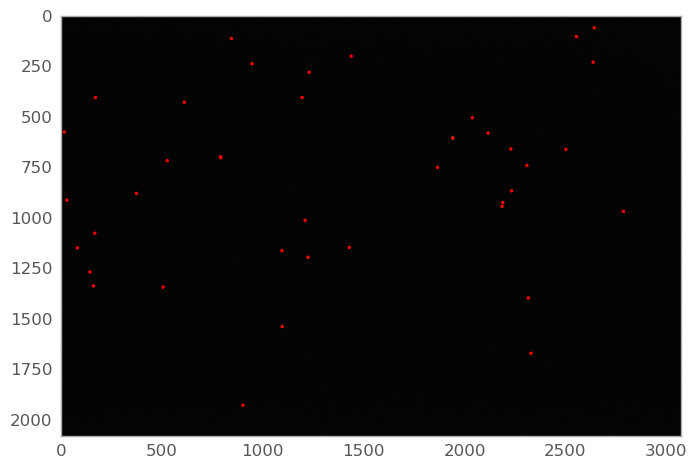

In [3]:
sext1 = ascii.read('/home/alam/task/task-inspecity/source-ex/test.cat',format = 'sextractor')
sext1.sort(['MAG_ISO'])
sext2 = sext1[0:40]
sextx = sext2['X_IMAGE']
sexty = sext2['Y_IMAGE']
sex_mag = sext2['MAG_ISO']
#hdul = fits.open('/home/alam/task/task-inspecity/source-ex/img-0001.fits')
#image_data = hdul[0].data



image_data = fits.getdata('/home/alam/task/task-inspecity/source-ex/img-0001.fits',ext = 0)
print(image_data.shape)
plt.figure()
plt.imshow(image_data,cmap = 'gray')
plt.grid(False)

for x_coord, y_coord in zip(sextx, sexty):
    circle = plt.Circle((x_coord, y_coord), radius=5, color='r', fill=False)
    plt.gca().add_patch(circle)

plt.show()


In [ ]:
#ascii.write([sextx, sexty, sex_mag], '/home/alam/task/task-inspecity/sext', delimiter = ' ', format = 'no_header', formats = {'col0':'% 15.10f', 'col1':'% 15.10f', 'col2':'% 15.10f'})

In [4]:
ra_dec = [(ra, dec) for ra in range(0, 360, 5) for dec in range(-80, 90, 5)]

def call_match(ra_dec):
    RA1, DEC1 = ra_dec
    # Transform RA and DEC in string and make the path for catalog.
    path_catalog1 = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Projected' +  '/cat_RA_'
    path_catalog2 = str(RA1) + '_DEC_' + str(DEC1)
    path_catalog3 = path_catalog1 + path_catalog2
    # Do Match.
    parameters1 = 'matchrad=3.0 trirad=0.001 nobj=40'
    command = 'match ' + '/home/alam/task/task-inspecity/sext' + ' 0 1 2 ' + path_catalog3 + ' 0 1 2 ' + parameters1
    
    results = subprocess.run(command, shell=True, capture_output=True, text=True)
    stdout_str = results.stdout
    return stdout_str

pool = multiprocessing.Pool(2)
results = pool.map(call_match, ra_dec)

In [5]:
results

['TRANS: a=-1.367240257e-01 b=-4.958863262e-04 c=1.172898094e-04 d=1.175470149e+00 e=-9.303472233e-05 f=-5.834340330e-04 sig=7.5101e-02 Nr=8 Nm=8 sx=1.5086e-01 sy=2.7639e-01 \n',
 'TRANS: a=2.076029114e+00 b=-9.803672059e-04 c=-1.077113337e-03 d=1.131298853e+00 e=-2.548872519e-04 f=-9.984815071e-05 sig=2.7465e-02 Nr=9 Nm=9 sx=9.9493e-02 sy=1.2087e-01 \n',
 'TRANS: a=3.908011980e-01 b=-3.663697244e-04 c=1.495103002e-04 d=2.592441092e-01 e=-5.360585031e-05 f=6.762262918e-04 sig=3.1378e-02 Nr=6 Nm=6 sx=1.9280e-01 sy=1.7716e-01 \n',
 'TRANS: a=-6.881420342e-01 b=2.950755592e-04 c=3.583579770e-04 d=-5.633851102e-01 e=-2.278153212e-05 f=9.750867960e-04 sig=2.1423e-02 Nr=6 Nm=7 sx=2.3676e-01 sy=1.7961e-01 \n',
 'TRANS: a=4.950168766e-01 b=1.274481871e-04 c=-1.345557915e-03 d=-1.237773077e+00 e=4.584410092e-04 f=4.680349469e-04 sig=2.7960e-02 Nr=10 Nm=12 sx=1.7282e-01 sy=2.3488e-01 \n',
 'TRANS: a=-1.004958203e+00 b=5.408872570e-04 c=2.709560005e-04 d=-5.243643997e-01 e=-2.456151258e-05 f=5.69

In [6]:
match1_table1 = Table(names=('RA_center', 'DEC_center', 'sig', 'Nr'))

In [7]:
for i, item in enumerate(results):
    RA1, DEC1 = ra_dec[i]
    
    
    match1_aux1 = item.find('sig=')
    match1_aux2 = item.find('Nr=')
    match1_auxsig1 = item[match1_aux1+4:match1_aux1+25]
    match1_auxnr1 = item[match1_aux2+3:match1_aux2+10]
    match1_sig1 = match1_auxsig1.split(' ', 1)[0]
    match1_nr1 = match1_auxnr1.split(' ', 1)[0]
    if match1_sig1 and match1_nr1:  # Check if both 'sig' and 'Nr' values are non-empty
            match1_table1.add_row([str(RA1), str(DEC1), match1_sig1, match1_nr1])

In [8]:
match1_table1.sort('Nr',reverse=True)

In [9]:
match1_table1

RA_center,DEC_center,sig,Nr
float64,float64,float64,float64
225.0,-25.0,0.018313,25.0
245.0,15.0,0.057204,24.0
175.0,-60.0,0.057847,24.0
240.0,-20.0,0.050207,23.0
105.0,-25.0,0.01854,23.0
100.0,-25.0,0.019944,23.0
235.0,-55.0,0.036385,22.0
150.0,-50.0,0.022892,22.0
100.0,-20.0,0.016329,22.0


In [18]:
match1_RA = int(match1_table1[0][0])
match1_DEC = int(match1_table1[0][1])
path_catalog1 = '/home/alam/task/task-inspecity/star_tracker/Star_Tracker/RPI/Catalog/Projected' +  '/cat_RA_'
path_catalog6 = str(match1_RA) + '_DEC_' + str(match1_DEC)
path_catalog7 = path_catalog1 + path_catalog6
parameters1 = 'matchrad=3.0 trirad=0.001 nobj=40'
Match2 = 'match ' + '/home/alam/task/task-inspecity/sext' + ' 0 1 2 ' + path_catalog7 + ' 0 1 2 ' + parameters1
results = subprocess.run(Match2, shell=True, capture_output=True, text=True)
stdout_str = results.stdout
stdout_str

'TRANS: a=8.825237100e-01 b=-8.787365686e-04 c=4.267119923e-04 d=-1.146838698e+00 e=-2.737031930e-04 f=9.018086645e-04 sig=1.8313e-02 Nr=25 Nm=25 sx=1.1085e-01 sy=8.5301e-02 \n'

In [15]:
match2_aux1 = stdout_str.find('a=')
match2_aux2 = stdout_str.find('b=')
match2_aux3 = stdout_str.find('c=')
match2_aux4 = stdout_str.find('d=')
match2_aux5 = stdout_str.find('e=')
match2_aux6 = stdout_str.find('f=')
match2_aux7 = stdout_str.find('sig=')
match2_aux8 = stdout_str.find('Nr=')
match2_auxa1 = stdout_str[match2_aux1+2:match2_aux1+25]
match2_auxb1 = stdout_str[match2_aux2+2:match2_aux2+25]
match2_auxc1 = stdout_str[match2_aux3+2:match2_aux3+25]
match2_auxd1 = stdout_str[match2_aux4+2:match2_aux4+25]
match2_auxe1 = stdout_str[match2_aux5+2:match2_aux5+25]
match2_auxf1 = stdout_str[match2_aux6+2:match2_aux6+25]
match2_auxsig4 = stdout_str[match2_aux7+4:match2_aux7+25]
match2_auxnr4 = stdout_str[match2_aux8+3:match2_aux8+10]
match2_auxa2 = match2_auxa1.split(' ', 1)[0]
match2_auxb2 = match2_auxb1.split(' ', 1)[0]
match2_auxc2 = match2_auxc1.split(' ', 1)[0]
match2_auxd2 = match2_auxd1.split(' ', 1)[0]
match2_auxe2 = match2_auxe1.split(' ', 1)[0]
match2_auxf2 = match2_auxf1.split(' ', 1)[0]
match2_sig = match2_auxsig4.split(' ', 1)[0]
match2_nr = match2_auxnr4.split(' ', 1)[0]
match2_a = float(match2_auxa2)
match2_b = float(match2_auxb2)
match2_c = float(match2_auxc2)
match2_d = float(match2_auxd2)
match2_e = float(match2_auxe2)
match2_f = float(match2_auxf2)

In [19]:
match2_c

0.0004267119923